<a href="https://colab.research.google.com/github/blabossiere/cap-comp215/blob/main/labs/lab06-GoL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

COMP 215 - LAB 6 (Game of Life)
-----------------------------------------------
#### Name: Brayden Labossiere
#### Date: Tuesday February 27, 2024

This lab exercise is an introduction to [Conway's Game of Life](https://en.wikipedia.org/wiki/Conway%27s_Game_of_Life) discovered and studied by [John Conway](https://en.wikipedia.org/wiki/John_Horton_Conway).

**New Python concepts**:
   * 2D numpy [array](https://numpy.org/doc/stable/reference/generated/numpy.array.html)
   * basic [array operations](https://www.pluralsight.com/guides/overview-basic-numpy-operations)

**New Computation concepts**:
   * [2D sliding dot product](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.correlate2d.html)
   * [Animation](https://matplotlib.org/stable/api/animation_api.html)

**Credits**:
    Code examples based on [Think Complexity, 2nd edition](https://thinkcomplex.com).
    Copyright 2016 Allen Downey, [MIT License](http://opensource.org/licenses/MIT)

As usual, the first code cell simply imports all the modules we'll be using...

In [1]:
import time
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import animation
import numpy as np
from scipy.signal import correlate2d
import math

%matplotlib inline
# Configure matplotlib's animation library to work in the browser.
matplotlib.rc('animation', html='jshtml')

A reusable function for plotting 2D numpy.array as an image...

In [2]:
def plot_2d_array(array, axes=None, title='', cmap='Blues', **options):
    """
    Plot the 2D array as an image on the given axes  1's will be dark blue, 0's will be light blue.

    :param axes: the axes to plot on, or None to use the `plt.gca()` (current axes)
    :param options: keyword arguments passed directly to `plt.imshow()`
           see https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.imshow.html
    """
    axes = axes or plt.gca()  # If not axes are provided, draw on current axes
    axes.set_title(title)
    # Turn off axes labels and tick marks
    axes.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False ,
                     labelbottom=False, labeltop=False, labelleft=False, labelright=False,)
    # Defaults for displaying a "matrix" with hard-pixel boundaries and (0,0) at top-left
    options = {**dict(interpolation='nearest', origin='upper'), **options}
    axes.imshow(array, cmap=cmap, **options)

## Life Fundamentals
Both the textbook and our week6 notebooks develop some fundamental operations for simulating the Game of Life.
Some of the code from `week6.ipynb` is reproduced here without deriving all the ideas - review `week6.ipynb` notebook for the full story.
The sliding dot product algorithm in `step` is implemented with [scipy.signal.correlate2d](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.correlate2d.html).  It's behaviour is identical to the derivation in `week6.ipynb`.

#### Notes
* we use `correlate2d(state, kernel, mode='same', boundary='wrap')` to pad state matrix with 1 value around perimeter from the opposite side of the matrix.
* since the rule is a 1D `np.array`, we use "vector indexing" here to set the 'live' state transitions:  `next_state[[3, 12, 13]] = 1`

In [3]:
class Life2D:
    """ An basic 2D Cellular Automata that implementes Conway's Game of Life """
    kernel = np.array([[1, 1, 1],
                       [1, 10, 1],
                       [1, 1, 1]])

    next_state = np.zeros(19, dtype=np.uint8)
    next_state[[3, 12, 13]] = 1

    def __init__(self, n_rows, n_cols=None):
        """ Construct a n_rows x n_cols 2D CA """
        n_cols = n_cols or n_rows  # i.e., n_cols if n_cols is not None and n_cols != 0 else n_rows
        self.state = np.zeros(shape=(n_rows, n_cols), dtype=np.uint8)

    def step(self):
        """Executes one time step. """
        transitions = correlate2d(self.state, self.kernel, mode='same', boundary='wrap')
        self.state = self.next_state[transitions]

    def draw(self, axes=None, step=''):
        axes = axes or plt.gca()   # use pyplot's current axes if none are provided.
        plot_2d_array(self.state, axes, title=f"Conway's Game of Life {step}")

### Visualizing a 2D simulation model
For 1D CAs, we could use a 2D image to visualize the CA progression over time.
For 2D CAs, we could try using time as a 3rd axis to generate a 3D visualziation, but without VR, its hard to explore a 3D visualization.
Instead, we'll use a simple 2D ["stop motion" animation](https://en.wikipedia.org/wiki/Animation).
Here is a generic class that animates any 2D model that provides step() and draw() methods, and uses matplotlib to render its state.

See [Matplotlib animation in Jupyter](https://www.allendowney.com/blog/2019/07/25/matplotlib-animation-in-jupyter/) by our textbook author for a discussion of the pros and cons of various animation techniques in jupyter notebooks.

In [4]:
class Animation2D:
    """
      Animates any 2D model with a step() method and a draw() method, using matplotlib
      model.step() should take no parameters - just step the model forward one step.
      model.draw() should take 2 parameters, the matpltolib axes to draw on and an integer step number
    """

    def __init__(self, model, frames=50, figsize=(8, 8)):
        """
        :param model: the simulation object to animate, with step() and draw(axes, step) methods
        :param frames: number of animation frames to generate
        """
        self.model = model
        self.frames = frames
        self.fig, self.ax = plt.subplots(figsize=figsize)

    def animation_step(self, step):
        """ Step the model forward and draw the plot """
        if step > 0:
            self.model.step()
        self.model.draw(self.ax, step=step)

    def show(self):
        """ return the matplotlib animation object, ready for display """
        anim = animation.FuncAnimation(self.fig, self.animation_step, frames=self.frames)
        plt.close()  # this ensures the last frame is not shown as a separate plot
        return anim

    def animate(self, interval=None):
        """ Animate the model simulation directly in the notebook display block """
        from IPython.display import clear_output
        try:
            for i in range(self.frames):
                clear_output(wait=True)  # clear the IPython display
                self.ax.clear()          # clear old image from the axes (fixes a performance issue)
                plt.figure(self.fig)     # add the figure back to pyplot ** sigh **
                self.animation_step(i)
                plt.show()               # show the current animation frame (pyplot then closes and throws away figure ** sigh **)
                if interval:
                    time.sleep(interval)
        except KeyboardInterrupt:
            pass

### Sample usage
Animate a single glider...

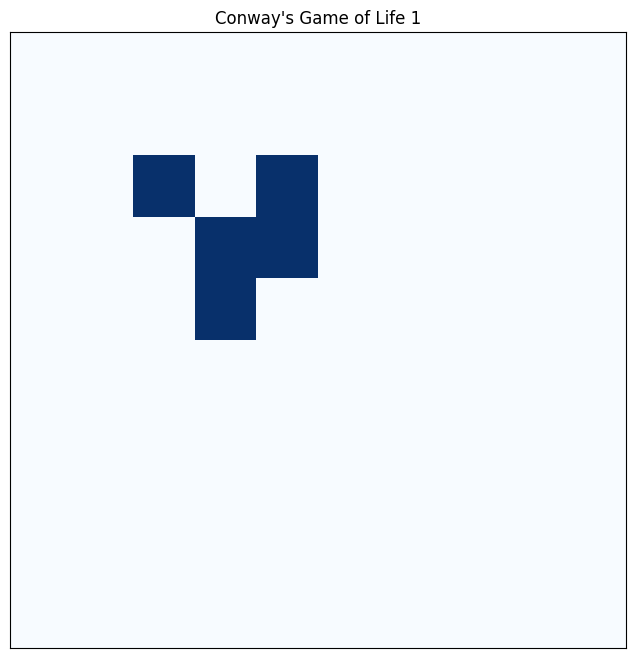

In [5]:
size = 10
life = Life2D(size)
glider = np.array([[0, 1, 0], [0, 0, 1], [1, 1, 1]], dtype=np.uint8)
life.state[1:4, 2:5] = glider             # bad idea to alter an objects state directly!  We'll improve it in Ex. 3
gol = Animation2D(life, frames=2)
gol.animate()

## Exercise 1:  Enumerate all Elementary 2D CA's
Write a line or 2 of code to compute and print the answer for each question:
* how many unique states are there for a 3x3 (9 cell) neighbourhood?
* how many unique “rules” are there? (where a rule provides a mapping for each possible neighbourhood state to the output for the centre cell)
* how does this number compare, for example, to the [number of atoms in the observable universe?](https://en.wikipedia.org/wiki/Observable_universe#Matter_content%E2%80%94number_of_atoms)

In [6]:
# Ex. 1 your code here...

unique_rules = 2 ** 2 ** 9
unique_rules2 = 2 ** 512
assert unique_rules == unique_rules2
print(unique_rules)

atoms_in_universe = 10 ** 82
print(atoms_in_universe)

magnitude_larger = (unique_rules / atoms_in_universe)
print(f'The number of unique rules fo the 3x3 neighbourhood is {magnitude_larger} times bigger than the number of atoms in the observable universe.')

13407807929942597099574024998205846127479365820592393377723561443721764030073546976801874298166903427690031858186486050853753882811946569946433649006084096
10000000000000000000000000000000000000000000000000000000000000000000000000000000000
The number of unique rules fo the 3x3 neighbourhood is 1.3407807929942597e+72 times bigger than the number of atoms in the observable universe.


Using what you learned above, concisely answer each question below (point form)1
1. would it be a reasonable goal to conduct an experiment like Wolfram’s for 2D CA’s?
2. propose a numbering scheme for these rules, analogous to Wolfram’s rule numbers
3. how might we go about determining which rule number corresponds to Conway’s GoL?
   (I’m not asking for the number, but rather for a method you could use to find it.)

#### Ex 1. Your Answers

1. .It would not be a reasonable goal to conduct an experiment like Wolfram's for 2D CA's because there are too many unique states.
2. .
3. .

## Exercise 2: random_life
Extend the Life2D class defined above to allow the game to be initialized with a random start state.
The liklihood of any given cell being initialized to "alive" is given by $p$.
*Hint*: we did this exact exercise for a 1D array in previous lab

In [7]:
# Ex. 2 experimental setup

class BetterLife2D(Life2D):
    """ Improvements on the basic Life2D model """

    def randomize_state(self, p):
        """ Randomize the state of this GoL, where probability of a "live" cell is p """
        # Ex. 2 your code here...
        random_array = np.random.choice([0,1], size = self.state.shape, p = (1-p, p))
        self.state = random_array


def random_life(p, n_rows, n_cols=None):
    """ Return a Life2D object of given dimensions with initial randomized state where "live" cells have probability p """
    # Ex. 2 your code here...
    owen = BetterLife2D(n_rows, n_cols)
    owen.randomize_state(p)
    return owen

# Class Instances


owen3 = random_life(0.5, 10, 10)
print(owen3)

#print(random_life(0.5, owen.n_rows, owen.n_cols))
#print(random_life(0.5, owen.n_rows, owen.n_cols)[0])

#print(owen3)

### Experiment
Run a small experiment to see if you can identify any relationship between $p$, the probability of a live cell in the initial grid, and the time it takes for the GoL pattern to stabilize.

In [8]:
# Ex. 2 write code for your experiment here...

# owen3 = random_life(0.45, 10, 10)

# animator = Animation2D(owen3)
# animator.show()


## Exercise 3: Load Patterns
People have discovered many interesting ["patterns"](https://conwaylife.com/wiki/Category:Patterns) that exhibit various types of behaviours.
A "pattern" is just a small 2D array.
 1. Develop a function that returns a 2D array containing the patterns defined by a single string; and
 2. Add a `load_pattern(x, y, pattern)` method to your `BetterLife2D` class above to insert patterns into the Life state array
    *Tip*: you can [assign an entire 2D slice of a numpy array](https://www.nickmccullum.com/advanced-python/numpy-indexing-assignment/) in a single assignment statement!   See example in the Sample Usage block above. Try it!

In [88]:
# Here's an example of the glider pattern from above defined in a single string...
glider_pattern = \
    """
    010
    001
    111
    """

# Ex. 3 your code here...

# for index in range(len(glider_pattern)):
#   print(index, glider_pattern[index])

# print(glider_pattern[5])
# print(glider_pattern[5] == '0')

""" Counts the characters in the string and prints the length and width of the array, as well as a list of the characters"""

# count = 0
# character_list = []
# for index in range(len(glider_pattern)): # Counts the characters in the string.
#   if glider_pattern[index] == '0':
#     count = count + 1
#     character_list.append(0)
#   if glider_pattern[index] == '1':
#     count = count + 1
#     character_list.append(1)
# print("count:", count)
# size = int(math.sqrt(count))
# print("row or column size:", size)
# print("character list:", character_list)

# array_of_zeros = np.zeros(shape = (size, size), dtype = np.uint8)
# print(array_of_zeros)

# for mini_list in range(size):
#   print("Mini list:", mini_list)
#   mini_list_size = int(len(character_list)/size)
# print("Mini list size:", mini_list_size)
#   i = i + 3
# print(super_list)

print("numpy super list:", '\n', np.array(super_list))

array_index = 0

class Life2D_III(BetterLife2D):
  """A class that allows the user to input various string patterns, as well as its entrance coordinates so it can be mapped in the larger array."""

  #state = Life2D.state

  def __init__(self, x, y, pattern):
    self.self = self
    self.x = x
    self.y = y
    self.pattern = pattern

  def load_pattern(self, x, y, pattern):
    """Takes the input of the x and y values for the pattern to be mapped onto the larger array.  Takes the input of the mapped pattern as well.
    The function updates the larger array with the pattern mapped onto it."""
    count = 0
    character_list = []
    for index in range(len(glider_pattern)): # Counts the characters in the string.
      if pattern[index] == '0':
        count = count + 1
        character_list.append(0)
      if pattern[index] == '1':
        count = count + 1
        character_list.append(1)
    print("count:", count)
    size = int(math.sqrt(count))
    print("row or column size:", size)
    print("character list:", character_list)

    mini_list_size = int(len(character_list)/size)
    i = 0
    super_list = []
    for x in range(size):
      mini_list = character_list[i:i+mini_list_size]
      print("mini list:", mini_list)
      super_list.append(mini_list)
      i = i + 3
    print(super_list)

    big_array = owen3.state
    big_array = np.zeros(shape = (10, 10), dtype=np.uint8)
    #print(big_array)
    print("indexed big array:", big_array[0][0])
    print("indexed big array:", big_array[0][0:3])
    print(len(big_array) - size)
    if y > len(big_array) - size or x > len(big_array) - size: # Checks that the pattern can be succesfully inserted into the array based on the pattern's size.
      print("Error, please select a valid x or y value.")
      return
    for index in range(size):
      big_array[x][y:y+size] = super_list[index]
      x = x + 1
    print(big_array)
    self.state = big_array
    return "not None"

owenIV = Life2D_III(0, 0, glider_pattern)

print(owenIV.x)

print(owenIV.load_pattern(owenIV.x, owenIV.y, glider_pattern))

numpy super list: 
 [[0 1 0]
 [0 0 1]
 [1 1 1]]
0
count: 9
row or column size: 3
character list: [0, 1, 0, 0, 0, 1, 1, 1, 1]
mini list: [0, 1, 0]
mini list: [0, 0, 1]
mini list: [1, 1, 1]
[[0, 1, 0], [0, 0, 1], [1, 1, 1]]
indexed big array: 0
indexed big array: [0 0 0]
7
[[0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0]
 [1 1 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
not None


In [89]:
animator_jr = Animation2D(owenIV)
animator_jr.show()

### Define some patterns
User your nifty new function to define a few common, interesting patterns (e.g., from the book or other sources)

In [ ]:
# Ex. 3 define your patterns here...

### Experiment
Load up a BetterLife2D object with some patterns that interact in some interesting way.
What can we learn from studying interactions like this?   Is anything here applicable to the real world?

In [ ]:
# Ex. 3 code for your experiment here